In [0]:
import numpy as np
import pandas as pd
import os, random, glob, cv2, gc
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from termcolor import colored

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip, RandomSizedCrop, Rotate, RandomBrightnessContrast, HueSaturationValue

from functools import partial
import scipy as sp
from zipfile import ZipFile
from PIL import Image

In [2]:
torch.cuda.empty_cache()
gc.collect()

15

In [0]:
!pip install kaggle -q

In [0]:
!rm -rf /root/.kaggle

In [0]:
!mkdir /root/.kaggle

In [0]:
!mv kaggle.json /root/.kaggle/kaggle.json

In [0]:
!ls /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download muerbingsha/pandatiledsingle

100% 2.98G/2.98G [01:03<00:00, 57.8MB/s]
100% 2.98G/2.98G [01:03<00:00, 50.4MB/s]


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': Not a directory


In [0]:
!mv kaggle.json /root/.kaggle/

mv: cannot move 'kaggle.json' to '/root/.kaggle/': Not a directory


In [0]:
!mkdir data
!mv pandatiledsingle.zip ./data/pandatiledsingle.zip

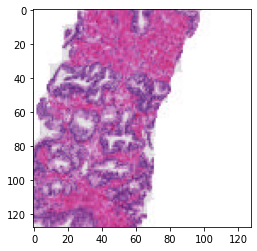

In [7]:
# read zip

with ZipFile('./data/pandatiledsingle.zip') as archive:
    for entry in archive.infolist():
        with archive.open(entry) as file:
            img = Image.open(file)
            img = np.array(img)
            plt.imshow(img)
            break    

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [0]:
class config:
    IMG_HEIGHT = 512
    IMG_WIDTH = 512
    BS = 8

# Data

In [0]:
df = pd.read_csv('./train.csv').set_index('image_id')

In [11]:
# shuffle
df = shuffle(df)

# split
train_df, val_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(val_df, test_size=0.2)

train_df = train_df.reset_index()
val_df = val_df.reset_index()
test_df = test_df.reset_index()

print(len(train_df), len(val_df), len(test_df))

8492 1699 425


In [12]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,9df270613df3c7eb10ec71bfc1aebde3,radboud,3,4+3
1,b9d20ddf4a37b9853aa63f0208a7d1e2,karolinska,1,3+3
2,4edeef3fc8d40f2f34d4a82cb13dc28d,karolinska,0,0+0
3,a0790fe0ac5caff880dab06f0218f3d4,karolinska,1,3+3
4,bc763ec4c8db4a23ae6c074bcf20e00b,karolinska,5,4+5


# Augmentation

In [0]:
mean = [1-0.90949707, 1-0.8188697, 1-0.87795304]
std = [0.36357649, 0.49984502, 0.40477625]
train_transforms = Compose([HorizontalFlip(p=0.5), 
                            VerticalFlip(p=0.5),
                            Rotate(p=0.3),
                            RandomBrightnessContrast(p=0.3),
                            HueSaturationValue(p=0.3),
                            Normalize(mean, std)])
val_transforms = Compose([Normalize(mean, std)])

# Test 

In [14]:
# test transformed effect
archive = ZipFile('./data/pandatiledsingle.zip')
entries = archive.infolist()
len(entries) // 16

10616

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


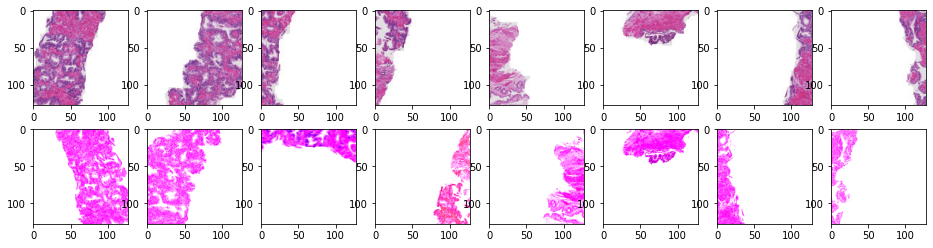

In [116]:
fig, ax = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):

    file = archive.open(entries[i])
    img = Image.open(file)
    img = np.array(img)
    ax[0, i].imshow(img)

    al_img = train_transforms(image=img)['image']
    ax[1, i].imshow(al_img)
    del file, img

# Dataset

In [0]:
class MyDataset(Dataset):
    def __init__(self, df, split='train'):
        super().__init__()
        self.df = df
        self.split = split
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name = self.df.image_id[idx] 
        

        # get the 16 imgs
        imgs = []
        for i in range(16):

            img_name = f'{name}-{i}.png'
            file = archive.open(img_name)
            img = Image.open(file)
            img = np.array(img)
            
            # apply transform to each img
            if self.split == 'train':
                img = train_transforms(**{'image': img})['image']
            elif self.split == 'val':
                img = val_transforms(**{'image': img})['image']
                
            imgs.append(img) # already tensor
        
        # concat
        final_img = cv2.vconcat([cv2.hconcat([imgs[0], imgs[1], imgs[2], imgs[3]]), 
                                 cv2.hconcat([imgs[4], imgs[5], imgs[6], imgs[7]]), 
                                 cv2.hconcat([imgs[8], imgs[9], imgs[10], imgs[11]]), 
                                 cv2.hconcat([imgs[12], imgs[13], imgs[14], imgs[15]])])
        final_img = cv2.resize(final_img, (config.IMG_HEIGHT, config.IMG_WIDTH))
        final_img = torch.tensor(final_img).permute(2, 0, 1)
        label = torch.tensor(self.df.isup_grade[idx])
        return final_img, label
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])


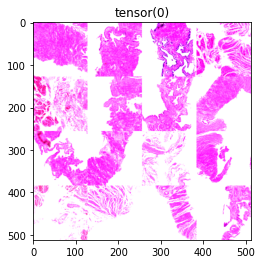

In [118]:
# test dataset
train_ds = MyDataset(train_df, 'train')
x, y = train_ds[2]
print(x.shape)
plt.imshow(x.permute(1, 2, 0).numpy())
plt.title(y)
del train_ds, x, y

In [0]:
train_ds = MyDataset(train_df[:1000], 'train')
train_dl = DataLoader(train_ds, batch_size=config.BS, shuffle=True, drop_last=True) # use 32 means 2 images per batch, don't shuffle to preserve 

val_ds = MyDataset(val_df, 'val')
val_dl = DataLoader(val_ds, batch_size=config.BS, shuffle=False, drop_last=True)

test_ds = MyDataset(test_df, 'val')
test_dl = DataLoader(test_ds, batch_size=config.BS, shuffle=False, drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'tensor(1)')

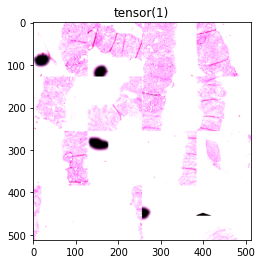

In [110]:
# test dl
x, y = next(iter(train_dl))
plt.imshow(x[0].permute(1, 2, 0).numpy())
plt.title(y[0])

# Model

In [0]:
from collections import OrderedDict
import math


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = config.pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = config.pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [0]:
class CustomSEResNeXt(nn.Module):

    def __init__(self, model_name='se_resnext50_32x4d'):
        assert model_name in ('se_resnext50_32x4d')
        super().__init__()
        
        self.model = se_resnext50_32x4d(pretrained=None)
        self.model.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.model.last_linear = nn.Linear(self.model.last_linear.in_features, 1)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [0]:
model = CustomSEResNeXt(model_name='se_resnext50_32x4d')
_ = model.to(device)
model.load_state_dict(torch.load('./seresnetxt-3.pth', map_location=device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.) # traditional lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, verbose=1)

In [0]:
# freeze 
# def freeze_until(model, name):
#     flag = False
#     for n, p in model.named_parameters():
#         if n == name:
#             flag = True
#         p.requires_grad = flag
# freeze_until(model, 'model.layer4.2.conv1.weight')

In [24]:
x = torch.tensor(np.random.randn(12, 3, 512, 512)).to(device).float()
print(model(x).shape)
del x

torch.Size([12, 1])


# Training

In [0]:
class OptimizedRounder():
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5

        ll = cohen_kappa_score(y, X_p, weights='quadratic')

        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef=[0.5, 1.5, 2.5, 3.5, 4.5]):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5
        return X_p

    def coefficients(self):
        '''use after self.fit or error throws'''
        return self.coef_['x']

In [0]:
rounder = OptimizedRounder()

In [0]:
cohen_prev = np.ones(len(train_dl)) + 1

def train_on(epoch):
    
    torch.cuda.empty_cache()
    gc.collect()
    
    model.train(True)
    
    loss_epoch = []
    preds_epoch = []
    y_epoch = []
    for i, (x, y) in tqdm(enumerate(train_dl), total=len(train_dl)):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        y_preds = model(x) # [batch, 1]
        y_preds = y_preds.view(-1) # [batch,]
        
        # get metrics
        loss = nn.MSELoss()(y_preds, y)

        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # add
        preds_epoch.append(y_preds.cpu().detach().numpy())
        y_epoch.append(y.cpu().detach().numpy())
        loss_epoch.append(loss.cpu().detach().numpy())


    # cohen
    preds_epoch = np.concatenate(preds_epoch) # float
    preds_epoch = rounder.predict(preds_epoch) # round to int
    y_epoch = np.concatenate(y_epoch)
    cohen = cohen_kappa_score(preds_epoch, 
                              y_epoch, 
                              weights='quadratic')
    
    print('Epoch: %d, Step: %d, Loss: %.4f, Cohen: %.4f' % (epoch, i, np.mean(loss_epoch), cohen))
    return np.mean(loss_epoch), cohen


In [122]:
torch.cuda.empty_cache()
gc.collect()

0

In [123]:
train_on(1)


Epoch: 1, Step: 124, Loss: 0.4615, Cohen: 0.9038


(0.46152255, 0.9038274162233947)

In [0]:
cohen_val_prev = np.ones(len(val_dl)) + 1

def val_on(epoch, dl):

    torch.cuda.empty_cache()
    gc.collect()
    
    model.eval()
    
    loss_epoch = []
    preds_epoch = []
    y_epoch = []
    for i, (x, y) in tqdm(enumerate(dl), total=len(dl)):
        with torch.no_grad():
            x = x.to(device)
            y = y.to(device)
            
            y_preds = model(x).view(-1)

            loss = nn.MSELoss()(y_preds, y)

            # add
            loss_epoch.append(loss.cpu().detach().numpy())
            preds_epoch.append(y_preds.cpu().detach().numpy())
            y_epoch.append(y.cpu().detach().numpy())

    
            # clean
            del x, y, y_preds
            torch.cuda.empty_cache()
            gc.collect()


    preds_epoch = np.concatenate(preds_epoch)
    y_epoch = np.concatenate(y_epoch)

    # final metrics
    rounder.fit(preds_epoch, y_epoch)
    coef = rounder.coefficients()
    final_preds = rounder.predict(preds_epoch, y_epoch)
    cohen = cohen_kappa_score(final_preds, y_epoch, weights='quadratic')

    print('Epoch: %d, Step: %d, Loss: %.4f, Cohen: %.4f' % (epoch, i, np.mean(loss_epoch), cohen))
    print('Coef: ', coef)

    return np.mean(loss_epoch), cohen
        
            

In [124]:
val_on(1, val_dl)


Epoch: 1, Step: 211, Loss: 0.3610, Cohen: 0.7243
Coef:  [0.50065563 1.52082306 2.22806386 3.69179916 4.63762678]


(0.36102575, 0.7243376978352936)

In [0]:
def train(epochs):
    best_cohen = []
    for e in range(epochs):
        train_loss, train_cohen = train_on(e)
        val_loss, val_cohen = val_on(e, val_dl)
        
        # adjust lr
        scheduler.step(val_loss)

        # save best
        best_cohen.append(val_cohen)
        if val_cohen >= max(best_cohen):
            print('save best model')
            torch.save(model.state_dict(), 'seresnetxt.pth')

In [126]:
train(10)


Epoch: 0, Step: 124, Loss: 0.4632, Cohen: 0.9019



Epoch: 0, Step: 211, Loss: 0.4188, Cohen: 0.6093
Coef:  [0.5825355  1.30006739 2.38711208 3.06325343 4.42359192]
save best model



Epoch: 1, Step: 124, Loss: 0.4670, Cohen: 0.9021



Epoch: 1, Step: 211, Loss: 0.3993, Cohen: 0.6636
Coef:  [0.51281893 1.50315538 2.57862828 3.38539599 4.37905259]
save best model



Epoch: 2, Step: 124, Loss: 0.4617, Cohen: 0.9038



Epoch: 2, Step: 211, Loss: 0.4246, Cohen: 0.7337
Coef:  [0.50090049 1.55910123 2.57256063 3.36691235 4.56516844]
save best model



Epoch: 3, Step: 124, Loss: 0.3623, Cohen: 0.9233



Epoch: 3, Step: 211, Loss: 0.4768, Cohen: 0.7877
Coef:  [0.42541156 1.70205394 2.66493218 3.69708859 4.83491662]
save best model



Epoch: 4, Step: 124, Loss: 0.3780, Cohen: 0.9246



Epoch: 4, Step: 211, Loss: 0.4100, Cohen: 0.7051
Coef:  [0.51754796 1.55654223 2.4352576  3.47202608 4.66633307]
Epoch     5: reducing learning rate of group 0 to 2.0000e-05.



Epoch: 5, Step: 124, Loss: 0.3061, Cohen: 0.9339



Epoch: 5, Step: 211, Loss: 0.3425, Cohen: 0.6686
Coef:  [0.52263502 1.63959277 2.40205884 3.33215794 4.27688683]



Epoch: 6, Step: 124, Loss: 0.2547, Cohen: 0.9480



Epoch: 6, Step: 211, Loss: 0.3288, Cohen: 0.6917
Coef:  [0.46658682 1.62194801 2.56218036 3.41896731 4.41686979]



Epoch: 7, Step: 124, Loss: 0.2442, Cohen: 0.9498



Epoch: 7, Step: 211, Loss: 0.3331, Cohen: 0.6906
Coef:  [0.52737078 1.62674155 2.48353334 3.27422077 4.37472355]



Epoch: 8, Step: 124, Loss: 0.2419, Cohen: 0.9465



Epoch: 8, Step: 211, Loss: 0.3254, Cohen: 0.6547
Coef:  [0.51843796 1.55858513 2.34410646 3.43416931 4.33323235]



Epoch: 9, Step: 124, Loss: 0.2379, Cohen: 0.9504



Epoch: 9, Step: 211, Loss: 0.3312, Cohen: 0.6396
Coef:  [0.53579975 1.61688154 2.21517108 3.34282091 4.2169069 ]


In [130]:
val_on(1, val_dl)


Epoch: 1, Step: 211, Loss: 0.3312, Cohen: 0.6396
Coef:  [0.53579975 1.61688154 2.21517108 3.34282091 4.2169069 ]


(0.3311608, 0.6395968559477155)

In [135]:
val_on(1, val_dl)


Epoch: 1, Step: 211, Loss: 0.4768, Cohen: 0.7877
Coef:  [0.42541156 1.70205394 2.66493218 3.69708859 4.83491662]


(0.47676855, 0.787659676275452)

In [136]:
val_on(1, test_dl)


Epoch: 1, Step: 52, Loss: 0.4512, Cohen: 0.8674
Coef:  [0.51523911 1.61156755 2.78831164 3.5075282  4.90978956]


(0.45123446, 0.8674237530974387)

In [128]:
val_on(1, test_dl)


Epoch: 1, Step: 52, Loss: 0.3064, Cohen: 0.8943
Coef:  [0.53562238 1.5720863  2.45044073 3.48206209 4.20734563]


(0.30642122, 0.8943091457486851)

In [0]:
torch.save(model.state_dict(), './fianl.pth')

In [133]:
model.load_state_dict(torch.load('seresnetxt.pth'))

<All keys matched successfully>